In [1]:
import gmsh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random
import matplotlib.image as mpimg
import scipy.sparse as sp
from scipy.sparse.linalg import eigs

In [2]:
def triangle_jacobian(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    
    jacobian = dx_deps*dy_deta - dx_deta*dy_deps
    return jacobian

In [3]:
def jac_matrix(x1,y1,x2,y2,x3,y3):
    dx_deps = -x1 + x2
    dx_deta = -x1 + x3
    dy_deps = -y1 + y2
    dy_deta = -y1 + y3
    jac = np.array([[dx_deps, dy_deps],[dx_deta, dy_deta]])
    return jac

In [4]:
def construct_bilinear(total_nodes, node_tags, triangle):
    
    n = total_nodes
    A_x = np.zeros((n,n))
    A_y = np.zeros((n,n))
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        a_x = np.zeros((3,3))
        a_y = np.zeros((3,3))
        jacobian = jac_matrix(x1,y1,x2,y2,x3,y3)
        dphi = np.linalg.inv(jacobian) @ np.array([[-1,1,0],[-1,0,1]])
        for j in range(len(weights)):
            # N_x = np.array([-1, 1, 0]) * (1/(x2-x1)) + np.array([-1, 0, 1])*(1/(x3-x1))
            # N_y = np.array([-1, 1, 0]) * (1/(y2-y1)) + np.array([-1, 0, 1])*(1/(y3-y1))
            x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            # kappa = properties(x,y)[0]
            N_x = dphi[0,:]
            N_y = dphi[1,:]
            N_x = N_x.reshape((3, 1))
            N_y = N_y.reshape((3, 1))
            a_x += (N_x @ N_x.T)*jac*weights[j]
            a_y += (N_y @ N_y.T)*jac*weights[j]
        
        for k in range(3):
            for l in range(3):
                A_x[int(nodes[k]-1), int(nodes[l]-1)] += a_x[k][l]
                A_y[int(nodes[k]-1), int(nodes[l]-1)] += a_y[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return A_x, A_y

In [5]:
def construct_mass(total_nodes, node_tags, triangle):
    
    n = total_nodes
    M = np.zeros((n,n))
    
    
    for i in range(len(node_tags)):
        nodes = node_tags[i]
        x1,y1,x2,y2,x3,y3 = triangle[i]
        jac = triangle_jacobian(x1,y1,x2,y2,x3,y3)
        pts = [[1/6, 2/3], [1/6, 1/6], [2/3, 1/6]]
        weights = [1/6, 1/6, 1/6]
        
        a_m = np.zeros((3,3))
        # a_pho_cp_delt = np.zeros((3,3))
        for j in range(len(weights)):
            # x = x1*(1-pts[j][0] - pts[j][1]) + x2*pts[j][0] + x3*pts[j][1]
            # y = y1*(1-pts[j][0] - pts[j][1]) + y2*pts[j][0] + y3*pts[j][1]
            N = np.array([1-pts[j][0] - pts[j][1], pts[j][0], pts[j][1]])
            N = N.reshape((3, 1))
            a_m += (N @ N.T)*jac*weights[j]
            # a_pho_cp_delt += (N @ N.T)*jac*weights[j]*(pho*cp/del_t)
            
        for k in range(3):
            for l in range(3):
                M[int(nodes[k]-1), int(nodes[l]-1)] += a_m[k][l]
                    
        # A_2d[0,0] += (numerical_intergation(neg_func, xi, xi_1)*jac)
        # A_2d[0,1] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,0] += (numerical_intergation(prod_func, xi, xi_1)*jac)
        # A_2d[1,1] += (numerical_intergation(pos_func, xi, xi_1)*jac)
        
        # A[i:i+2, i:i+2] += A_2d
        
    return M

In [6]:
def cal_eigen(M,K):
    eigenvalues, eigenvectors = eigs(K, M = M, k= K.shape[0]-2, sigma = 0, which = 'LM')
    return eigenvalues, eigenvectors

In [7]:
num = [12.5, 10, 7.5, 5, 4, 3]
# num = [10]
total_triangles_array = []
norm_array = []

for i in range(len(num)):
    gmsh.initialize()

    # gmsh.open('IITM_Map_final')
    # gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
    gmsh.open(f'Q2_file_sf{num[i]}')
    
    # Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
    nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

    # Total number of nodes is the length of nodeTags
    total_nodes = len(nodeTags)
    coordinates = coordinates.reshape((-1, 3))

    sorted_indices = np.argsort(nodeTags)
    sorted_coordinates = coordinates[sorted_indices]


    # coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
    dim = 2 #for triangles
    tag = -1 #get all
    ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
    node_tags = node_tags.reshape((-1,3))

    triangle = []
    for tag, nodes in zip(ele_tags, node_tags):
        x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
        x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
        x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
        # area1 = heron(point[0], point[1], x2,y2,x3,y3)
        # area2 = heron(point[0], point[1], x1,y1,x3,y3)
        # area3 = heron(point[0], point[1], x2,y2,x1,y1)
        # area = heron(x1, y1, x2,y2,x3,y3)
        # if area == area1 + area2 + area3:
        #     point_indices.append(nodes[0]-1)
        #     point_indices.append(nodes[0]-1)
        #     point_indices.append(nodes[0]-1)
        #     point_coordinates = [x1, y1, x2, y2, x3, y3]
            
        #     point_indices_total.append(point_indices)
        #     point_coordinates_final.append(point_coordinates)
            
        triangle.append([x1,y1,x2,y2,x3,y3])
        
    triangle = np.array(triangle)

    total_triangles_array.append(node_tags.shape[0])
    A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
    # f = construct_forcing(total_nodes, node_tags, triangle)
    K = A_x + A_y
    M = construct_mass(total_nodes, node_tags, triangle)
    eigenvalues, eigenvectors = cal_eigen(M,K)
    eigenvalues = np.sort(eigenvalues)
    
    norm = np.linalg.norm(eigenvalues[0:5])
    norm_array.append(norm)
    

In [8]:
eigenvalues

array([1.69478714e-17+0.j, 2.07792435e-04+0.j, 7.54464074e-04+0.j, ...,
       3.94368628e+00+0.j, 3.94760532e+00+0.j, 4.06163031e+00+0.j])

In [9]:
norm

0.0021563988539986764

In [10]:
norm_array

[0.002173158174559384,
 0.002168036869972063,
 0.002163103167856368,
 0.0021586996741308744,
 0.0021574365616081723,
 0.0021563988539986764]

In [11]:
total_triangles_array

[454, 626, 990, 2143, 3228, 5550]

In [12]:
norm_array

[0.002173158174559384,
 0.002168036869972063,
 0.002163103167856368,
 0.0021586996741308744,
 0.0021574365616081723,
 0.0021563988539986764]

Text(0.5, 1.0, 'Mesh Convergence Plot')

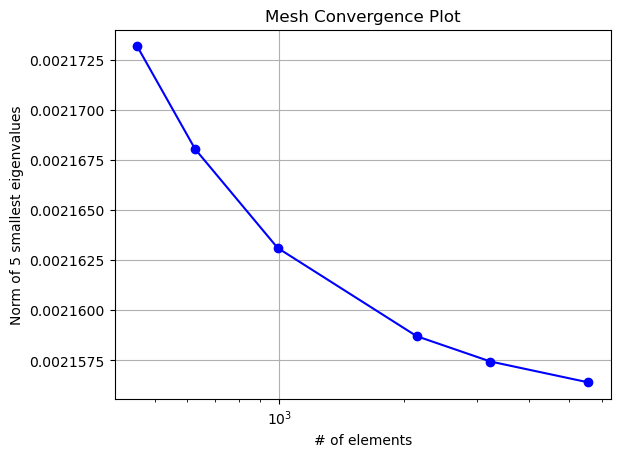

In [13]:
plt.plot(total_triangles_array[:6], norm_array, marker = 'o', color = 'blue', linestyle = '-', markersize=6)
plt.xlabel("# of elements")
plt.ylabel("Norm of 5 smallest eigenvalues")
plt.xscale('log')  # Set x-axis to log scale
plt.grid(True)
plt.title("Mesh Convergence Plot")  # Title

Plotting eigenvectors

In [478]:
source_point = np.array([482, 376])

In [530]:
gmsh.initialize()

# gmsh.open('IITM_Map_final')
# gmsh.open(f'IITM_Map_lc_{num[i]}.msh')
gmsh.open(f'Q2_file_sf12.5')

# Unpack the three return values (nodeTags, coordinates, parametricCoordinates)
nodeTags, coordinates, _ = gmsh.model.mesh.getNodes(-1, -1)

# Total number of nodes is the length of nodeTags
total_nodes = len(nodeTags)
coordinates = coordinates.reshape((-1, 3))

sorted_indices = np.argsort(nodeTags)
sorted_coordinates = coordinates[sorted_indices]


# coordinates = (gmsh.model.mesh.getNodes(-1,-1))[1].reshape((-1,3))
dim = 2 #for triangles
tag = -1 #get all
ele_tags, node_tags = gmsh.model.mesh.getElementsByType(dim, tag)
node_tags = node_tags.reshape((-1,3))

triangle = []
for tag, nodes in zip(ele_tags, node_tags):
    x1 , y1 = list(coordinates[int(nodes[0]-1),:-1])
    x2 , y2 = list(coordinates[int(nodes[1]-1),:-1])
    x3 , y3 = list(coordinates[int(nodes[2]-1),:-1])
    # area1 = heron(point[0], point[1], x2,y2,x3,y3)
    # area2 = heron(point[0], point[1], x1,y1,x3,y3)
    # area3 = heron(point[0], point[1], x2,y2,x1,y1)
    # area = heron(x1, y1, x2,y2,x3,y3)
    # if area == area1 + area2 + area3:
    #     point_indices.append(nodes[0]-1)
    #     point_indices.append(nodes[0]-1)
    #     point_indices.append(nodes[0]-1)
    #     point_coordinates = [x1, y1, x2, y2, x3, y3]
        
    #     point_indices_total.append(point_indices)
    #     point_coordinates_final.append(point_coordinates)
        
    triangle.append([x1,y1,x2,y2,x3,y3])
    
triangle = np.array(triangle)

total_triangles_array.append(node_tags.shape[0])
A_x, A_y = construct_bilinear(total_nodes, node_tags, triangle)
# f = construct_forcing(total_nodes, node_tags, triangle)
K = A_x + A_y
M = construct_mass(total_nodes, node_tags, triangle)
eigenvalues, eigenvectors = cal_eigen(M,K)
xy_coordinates = sorted_coordinates[:, :2]
source_point_index = np.argmin(np.sum((xy_coordinates - source_point)**2, axis=1))

In [531]:
eigenvalues

array([2.26111848e-20+0.j, 2.08019169e-04+0.j, 7.57686486e-04+0.j,
       1.29824416e-03+0.j, 1.55557635e-03+0.j, 1.93917411e-03+0.j,
       2.43953025e-03+0.j, 3.05931830e-03+0.j, 3.50707659e-03+0.j,
       4.52330449e-03+0.j, 4.76623062e-03+0.j, 5.12511886e-03+0.j,
       5.90952440e-03+0.j, 6.34729049e-03+0.j, 6.58965300e-03+0.j,
       7.55096599e-03+0.j, 8.20450200e-03+0.j, 8.58539752e-03+0.j,
       9.63535157e-03+0.j, 1.03880642e-02+0.j, 1.07134572e-02+0.j,
       1.14682043e-02+0.j, 1.18645811e-02+0.j, 1.25060960e-02+0.j,
       1.32267704e-02+0.j, 1.33885180e-02+0.j, 1.43494036e-02+0.j,
       1.49884642e-02+0.j, 1.56541055e-02+0.j, 1.64375576e-02+0.j,
       1.73809919e-02+0.j, 1.78594340e-02+0.j, 1.86152440e-02+0.j,
       2.00176279e-02+0.j, 2.04489359e-02+0.j, 2.11141031e-02+0.j,
       2.13349938e-02+0.j, 2.20625194e-02+0.j, 2.29345669e-02+0.j,
       2.36697123e-02+0.j, 2.42981165e-02+0.j, 2.49265211e-02+0.j,
       2.59626914e-02+0.j, 2.61799766e-02+0.j, 2.76448948e-02+

In [535]:
eigenvectors[:,0].shape

(257,)

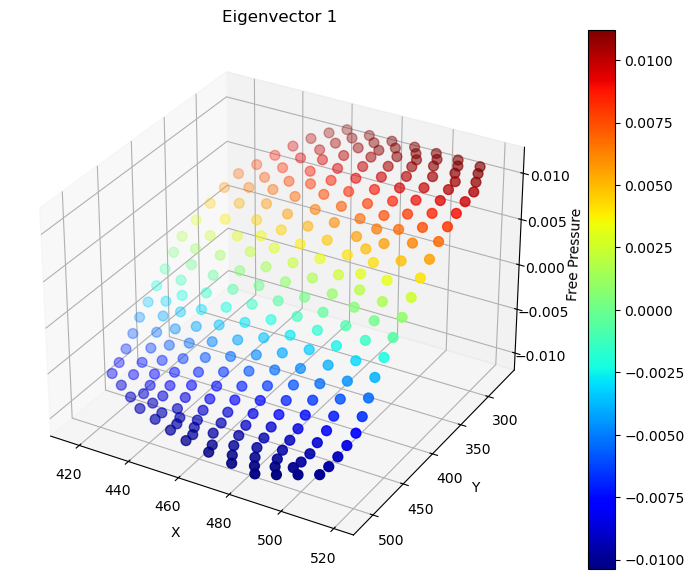

In [567]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = eigenvectors.real[:,1]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Eigenvector 1')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Free Pressure')

# Invert the y-axis if needed
ax.invert_yaxis()

# Show the plot
plt.show()

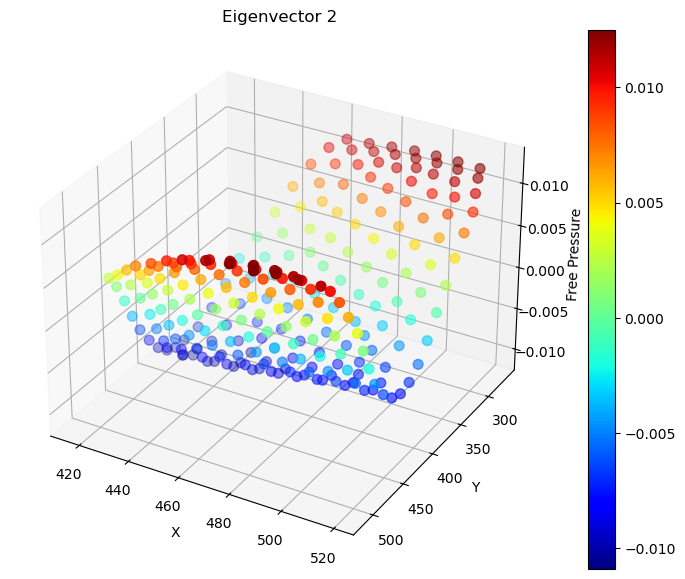

In [568]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = eigenvectors.real[:,2]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Eigenvector 2')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Free Pressure')

# Invert the y-axis if needed
ax.invert_yaxis()

# Show the plot
plt.show()

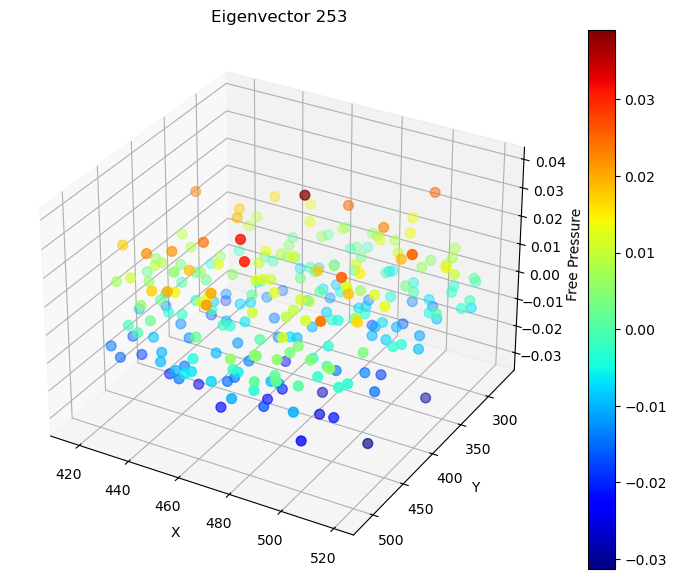

In [604]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = eigenvectors.real[:,253]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Eigenvector 253')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Free Pressure')

# Invert the y-axis if needed
ax.invert_yaxis()

# Show the plot
plt.show()

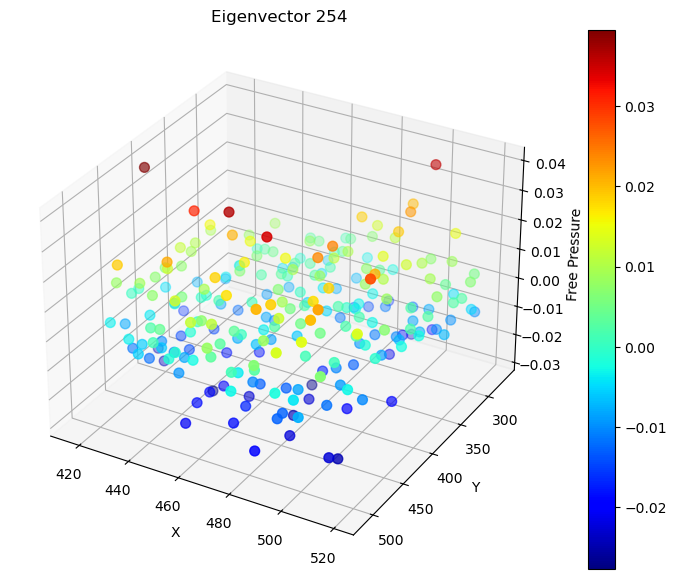

In [605]:
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
temperature = eigenvectors.real[:,254]

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Eigenvector 254')

# Add a 3D scatter plot of the original data points
scatter = ax.scatter(x, y, temperature, c=temperature, cmap='jet', s=50)  # Scatter points

# Add a color bar
fig.colorbar(scatter, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Free Pressure')

# Invert the y-axis if needed
ax.invert_yaxis()

# Show the plot
plt.show()

In [577]:
random_integers = [20,21,22,23,24]

In [578]:
frequencies = eigenvalues[random_integers]

In [579]:
forcing = np.zeros((total_nodes,1))
forcing[source_point_index] = 0.1

In [580]:
main_gate = np.array([458, 398])
students_gate = np.array([454, 381])
badminton = np.array([456, 347])
fountain = np.array([448, 364])

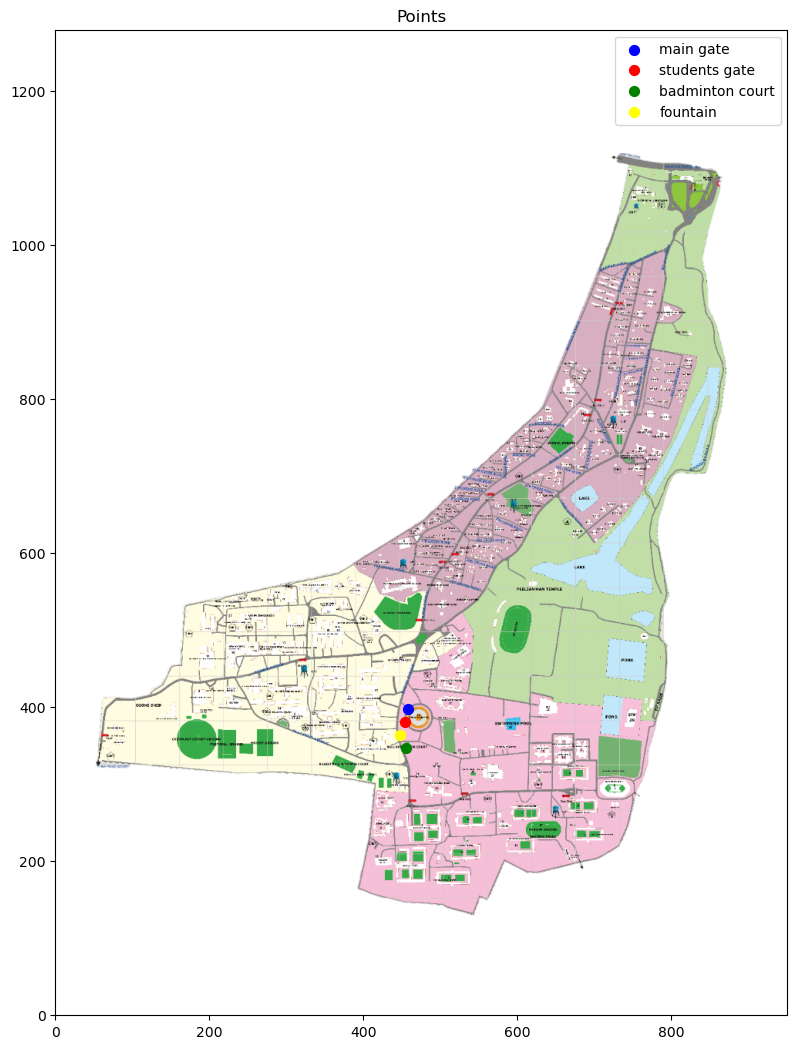

In [581]:
img = mpimg.imread('IITM_map_without_background.png')
img_height, img_width = img.shape[:2]  # Get image dimensions

# plt.imshow(image_rgb)
plt.figure(figsize=(img_width/100, img_height/100))  # Adjust figure size to match image size in inches

# Plot the image at its original size
plt.imshow(img, extent=[0, img_width, 0, img_height])
# # Plot the map, region boundary, and point
# plt.imshow(img)


# Plot the point you want to check
plt.scatter(main_gate[0], main_gate[1], c='blue', label='main gate', s=50)  # Larger point for the query location
plt.scatter(students_gate[0], students_gate[1], c='red', label='students gate', s=50)  # Larger point for the query location
plt.scatter(badminton[0], badminton[1], c='green', label='badminton court', s=50)  # Larger point for the query location
plt.scatter(fountain[0], fountain[1], c='yellow', label='fountain', s=50)  # Larger point for the query location


plt.title(f"Points")
plt.legend()
plt.show()

In [582]:
xy_coordinates = sorted_coordinates[:, :2]
main_gate_index = np.argmin(np.sum((xy_coordinates - main_gate)**2, axis=1))
students_gate_index = np.argmin(np.sum((xy_coordinates - students_gate)**2, axis=1))
badminton_index = np.argmin(np.sum((xy_coordinates - badminton)**2, axis=1))
fountain_index = np.argmin(np.sum((xy_coordinates - fountain)**2, axis=1))

In [583]:
p_array = []
for eigen in frequencies:
    lhs = K - eigen*M
    p = np.linalg.solve(lhs, forcing)
    p_array.append(p)

In [584]:
# Stack the m arrays into a single (m, n, 1) array
stacked_arrays = np.stack(p_array, axis=0)  # shape: (m, n, 1)
print(stacked_arrays.shape)

# Square the values
squared_arrays = np.square(stacked_arrays)

# Take the mean along the first axis (m)
mean_squared = np.mean(squared_arrays, axis=0)

# Compute the RMS values
p_array_final = np.sqrt(mean_squared)


(5, 257, 1)


In [585]:
sorted_coordinates[source_point_index]

array([483.86837518, 373.53339763,   0.        ])

In [586]:
np.average(p_array_final)

(1353867887874.574+0j)

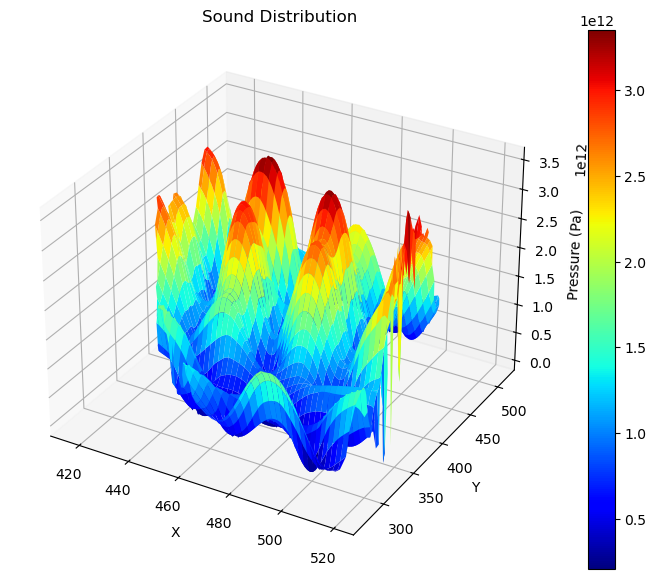

In [595]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
# Assuming coordinates is a (N, 2) array and C_steady contains the temperature
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = p_array_final.real[:, 0]

# Create a grid of points for plotting (interpolating data onto this grid)
xi = np.linspace(np.min(x), np.max(x), 100)
yi = np.linspace(np.min(y), np.max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate temperature onto the grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Sound Distribution')
# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap='jet')

# Add a color bar
fig.colorbar(surf, ax=ax)

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Pressure (Pa)')

# ax.invert_yaxis()  # Flip the y-axis if needed

# Show the plot
plt.show()

In [590]:
decibel_array = 20*np.log10(p_array_final/2e-5)

In [591]:
decibel_array[source_point_index]

array([341.3575987+0.j])

c:\Users\Pratham Sunkad\anaconda3\envs\pytorch\Lib\site-packages\matplotlib\cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


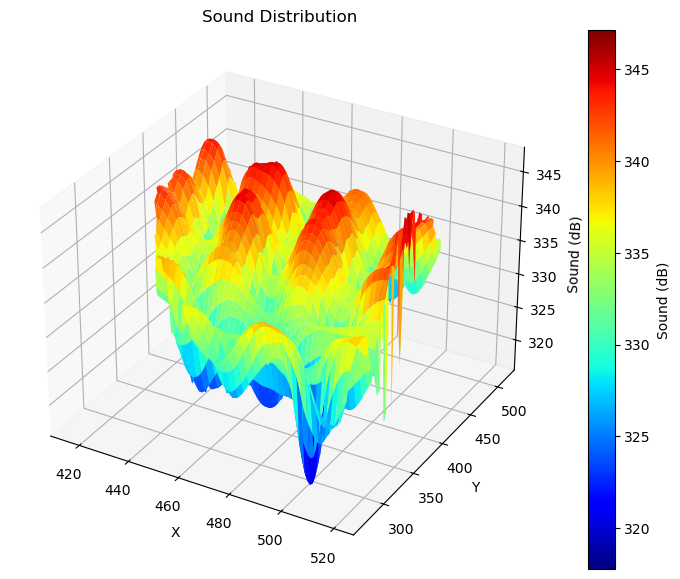

In [592]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
# Assuming coordinates is a (N, 2) array and C_steady contains the temperature
x = sorted_coordinates[:, 0]
y = sorted_coordinates[:, 1]
z = decibel_array[:, 0]

# Create a grid of points for plotting (interpolating data onto this grid)
xi = np.linspace(np.min(x), np.max(x), 100)
yi = np.linspace(np.min(y), np.max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate temperature onto the grid
zi = griddata((x, y), z, (xi, yi), method='cubic')

# Create a 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Sound Distribution')
# Plot the surface
surf = ax.plot_surface(xi, yi, zi, cmap='jet')

# Add a color bar
fig.colorbar(surf, ax=ax, label='Sound (dB)')

# Labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Sound (dB)')

# ax.invert_yaxis()  # Flip the y-axis if needed

# Show the plot
plt.show()

In [594]:
# main_gate_pressure = 0
# students_gate_pressure = 0
# badminton_pressure = 0
# fountain_pressure = 0
# num = len(p_array)  
# for i in range(num):
#     main_gate_pressure +=  (p[main_gate_index]**2)/num
#     students_gate_pressure +=  (p[students_gate_index]**2)/num
#     badminton_pressure +=  (p[badminton_index]**2)/num
#     fountain_pressure +=  (p[fountain_index]**2)/num
    
    
  
# main_gate_pressure  = main_gate_pressure**0.5
# students_gate_pressure = students_gate_pressure**0.5 
# badminton_pressure  = badminton_pressure**0.5
# fountain_pressure  = fountain_pressure**0.5

main_db = decibel_array[main_gate_index]
students_db = decibel_array[students_gate_index]
badminton_db = decibel_array[badminton_index]
fountain_db = decibel_array[fountain_index]

print(f'Measured Value:     Main Gate: 63       Students Gate: 65       Badminton Court: 49     Fountain: 54')
print(f'Analytic Value:     Main Gate: {main_db.real}     Students Gate: {students_db.real}       Badminton Court: {badminton_db.real}     Fountain: {fountain_db.real}')

Measured Value:     Main Gate: 63       Students Gate: 65       Badminton Court: 49     Fountain: 54
Analytic Value:     Main Gate: [341.30121302]     Students Gate: [340.99781745]       Badminton Court: [337.58519684]     Fountain: [339.13002687]
